In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# (re-)load layers
%run modules.ipynb

In [2]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1

In [3]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [4]:
from mlxtend.data import loadlocal_mnist

# Load and preprocess MNIST dataset
x_train, y_train = loadlocal_mnist(
        images_path='Dataset/train-images.idx3-ubyte', 
        labels_path='Dataset/train-labels.idx1-ubyte')
x_test, y_test = loadlocal_mnist(
        images_path='Dataset/t10k-images.idx3-ubyte',
        labels_path='Dataset/t10k-labels.idx1-ubyte')

train_samples_count = y_train.shape[0]
test_samples_count = y_test.shape[0]
features_count = x_train.shape[1]
classes_count = y_train.max() + 1

x_train_max_abs = np.max(np.abs(x_train.max()), np.abs(x_train.min()))
x_train = x_train.astype(float) / x_train_max_abs

x_test_max_abs = np.max(np.abs(x_test.max()), np.abs(x_test.min()))
x_test = x_test.astype(float) / x_test_max_abs

In [5]:
# Onehot
y_train_oh = np.zeros((y_train.shape[0], classes_count), dtype=float)
y_test_oh = np.zeros((y_test.shape[0], classes_count), dtype=float)

for i in range(train_samples_count):
    y_train_oh[i][y_train[i]] = 1.0
    
for i in range(test_samples_count):
    y_test_oh[i][y_test[i]] = 1.0

In [6]:
# Parameters
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 5
batch_size = 200

In [7]:
# Build net

net = Sequential()
net.add(Linear(features_count, 500))
net.add(ReLU())
net.add(Dropout(0.8))
net.add(Linear(500, 250))
net.add(Sigmoid())
net.add(Linear(250, 50))
net.add(SoftPlus())
net.add(Linear(50, 10))
net.add(SoftMax())

criterion = MSECriterion()

print(net)

Linear 784 -> 500
ReLU
Dropout
Linear 500 -> 250
Sigmoid
Linear 250 -> 50
SoftPlus
Linear 50 -> 10
SoftMax



### Train

Basic training loop. Examine it.

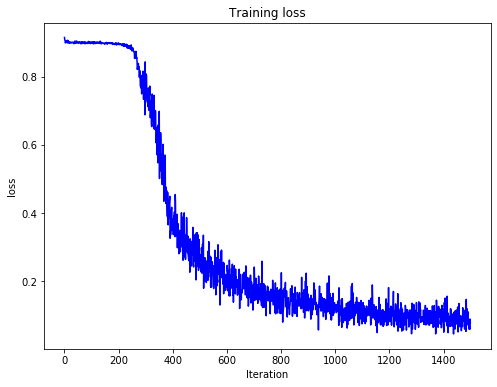

Current loss: 0.078671


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((x_train, y_train_oh), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("Iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)